# timeseries_us_data.ipynb

Analyze COVID-19 statistics over time for all counties in the United States.

Inputs:
* `outputs/us_counties_clean.feather`: The contents of `data/us_counties.csv` after data cleaning by [clean_us_data.ipynb](./clean_us_data.ipynb)
* `outputs/dates.feather`: Dates that go with the points in the time series in `outputs/us_counties_clean.feather`, produced by [clean_us_data.ipynb](./clean_us_data.ipynb).

**Note:** You can redirect these input files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

# Size of the line charts in this notebook, in inches
_FIGSIZE = (13, 8)

# Globally adjust the font size for matplotlib.
plt.rcParams.update({'font.size': 16})

In [2]:
# Read time series data from the binary file that clean_us_data.ipynb produces
dates_file = os.path.join(_OUTPUTS_DIR, "dates.feather")
cases_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean.feather")
cases = pd.read_feather(cases_file).set_index("FIPS")
dates = pd.read_feather(dates_file)["date"].to_numpy()
cases.head()

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier,Confirmed_7_Days,Deaths_7_Days
FIPS,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,153,3
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,573,0
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,31,1
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,149,0
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,189,2


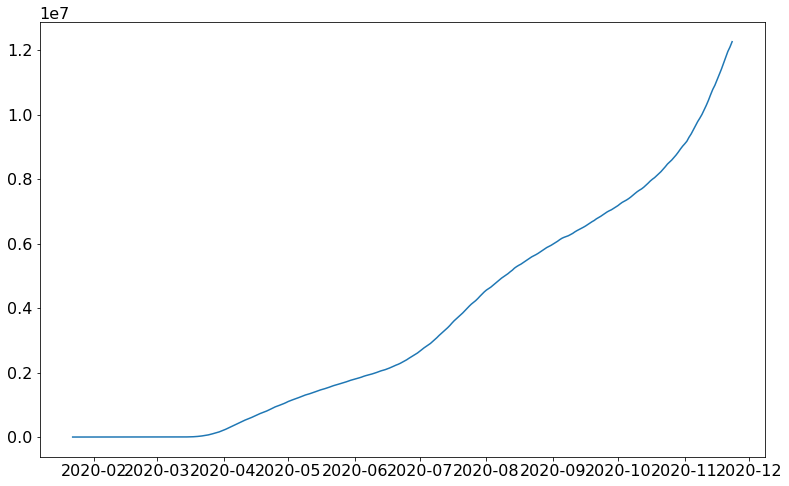

In [3]:
# Draw a graph of confirmed cases over time in the U.S.
plt.figure(figsize=_FIGSIZE)
plt.plot(dates, np.transpose(cases["Confirmed"].sum()))
plt.show()

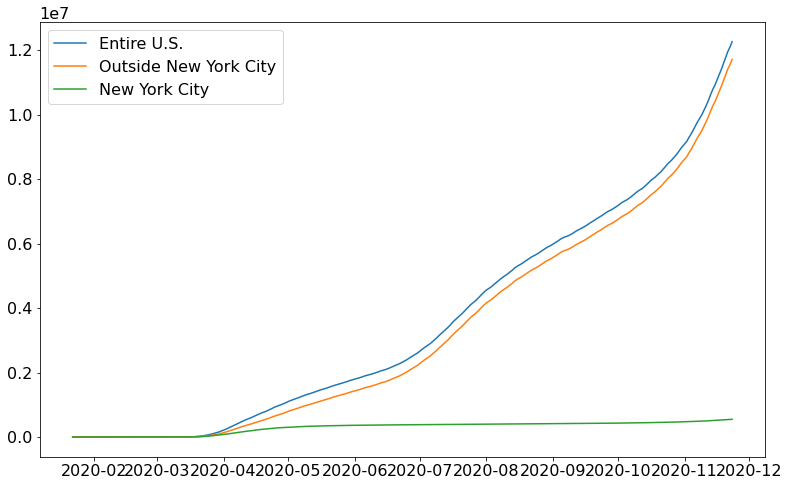

In [4]:
# Draw a graph of total cases over time in the U.S., excluding New York City
# and counties adjacent to New York City

# List of the FIPS codes for counties inside New York City
nyc_fips = [
    36005,  # Bronx County
    36047,  # Kings County
    36061,  # New York County
    36081,  # Queens County
    36085,  # Richmond County
]

# List of FIPS codes for counties close to New York City
nyc_adjacent_fips = [
    # Immediately adjacent to NYC
    34023,  # Middlesex County, NJ
    34039,  # Union County, NJ
    34013,  # Essex County, NJ
    34017,  # Hudson County, NJ
    34003,  # Bergen County, NJ
    36119,  # Westchester County, NY
    36059,  # Nassau County, NY
    
    # Uncomment the following lines to also include counties that are 
    # 1 county away from New York City.
#     34025,  # Monmouth County, NJ
#     34021,  # Mercer County, NJ
#     34035,  # Somerset County, NJ
#     34027,  # Morris County, NJ
#     34031,  # Passaic County, NJ
#     36087,  # Rockland County, NY
#     36071,  # Orange County, NY
#     36079,  # Putnam County, NY
#     9001,   # Fairfield County, CT
#     36103,  # Suffolk County, NY
]

plt.figure(figsize=_FIGSIZE)

mask = ~cases.index.isin(nyc_fips + nyc_adjacent_fips)

plt.plot(dates, np.transpose(cases["Confirmed"].sum()), label="Entire U.S.")
plt.plot(dates, np.transpose(cases[mask]["Confirmed"].sum()), label="Outside New York City")
plt.plot(dates, np.transpose(cases[~mask]["Confirmed"].sum()), label="New York City")
plt.legend()
plt.show()

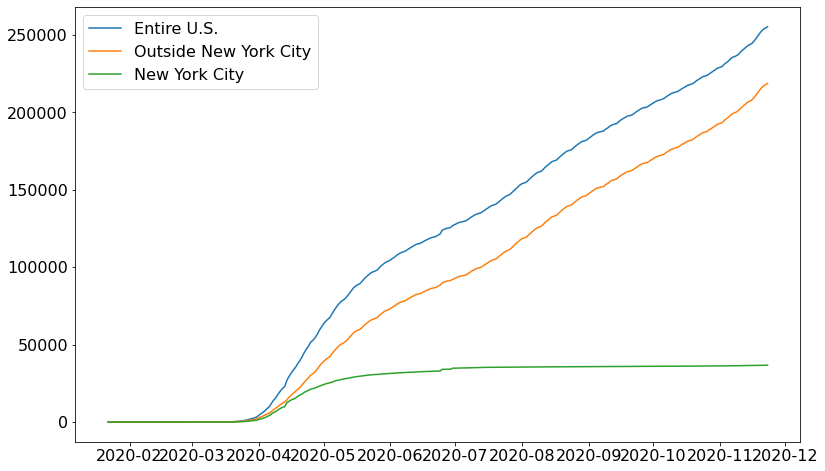

In [5]:
# Repeat the previous graph for the "Deaths" time series.
plt.figure(figsize=_FIGSIZE)
plt.plot(dates, np.transpose(cases["Deaths"].sum()), label="Entire U.S.")
plt.plot(dates, np.transpose(cases[mask]["Deaths"].sum()), label="Outside New York City")
plt.plot(dates, np.transpose(cases[~mask]["Deaths"].sum()), label="New York City")
plt.legend()
plt.show()

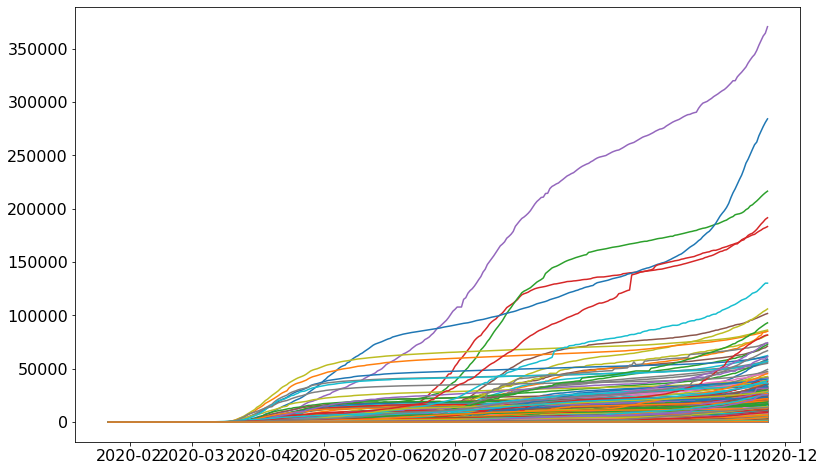

In [6]:
# Plot all the "Confirmed" time series
plt.figure(figsize=_FIGSIZE)
plt.plot(dates, np.transpose(cases["Confirmed"].array))
plt.show()

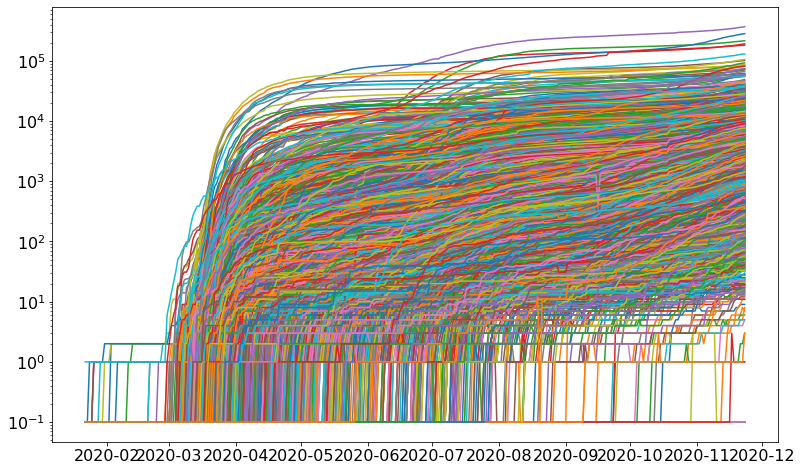

In [7]:
# Repeat the previous plot, but with a log scale
plt.figure(figsize=_FIGSIZE)

plt.yscale("log")
plt.plot(dates, np.transpose(np.maximum(1e-1, cases["Confirmed"].array)))
plt.show()

In [8]:
# The time series in the above plot appear to have a very wide spread --
# multiple orders of magnitude. Much of this spread goes away, however,
# if we normalize the time series for each county to the county's 
# population. Let's do that normalization for all our time series.
#
# The main dataframe is getting crowded at this point, so generate a 
# second dataframe with the same index.
cases_per_100 = cases[["State", "County", "Population"]].copy()
cases_per_100["Confirmed_per_100"] = 100.0 * cases["Confirmed"].array / cases["Population"].values.reshape(-1,1)
cases_per_100["Deaths_per_100"] = 100.0 * cases["Deaths"].array / cases["Population"].values.reshape(-1,1)
cases_per_100["Recovered_per_100"] = 100.0 * cases["Recovered"].array / cases["Population"].values.reshape(-1,1)

# (shallow) copy the outlier masks so our graphing function can use them
cases_per_100["Confirmed_per_100_Outlier"] = cases["Confirmed_Outlier"]
cases_per_100["Deaths_per_100_Outlier"] = cases["Deaths_Outlier"]
cases_per_100["Confirmed_per_100_Outlier"] = cases["Confirmed_Outlier"]

cases_per_100

,State,County,Population,Confirmed_per_100,Deaths_per_100,Recovered_per_100,Confirmed_per_100_Outlier,Deaths_per_100_Outlier
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[0.00000000e+00 0.00000000e+00 0.00000000e+00 0...,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0....,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


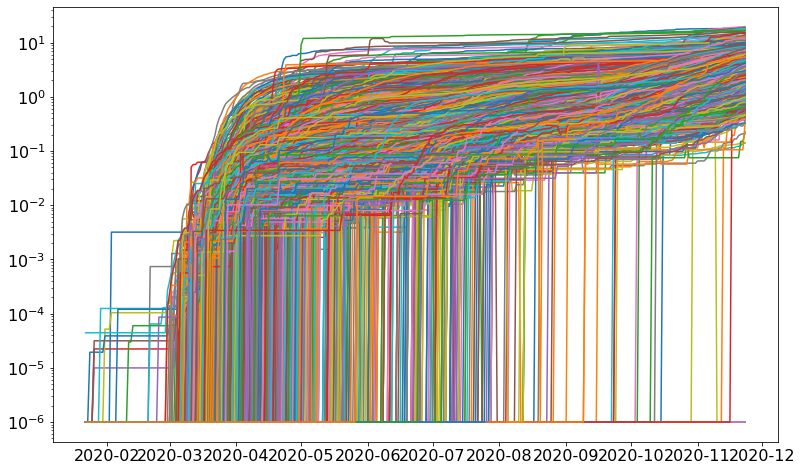

In [9]:
# Plot confirmed cases normalized to population, with a log scale on the Y axis
plt.figure(figsize=_FIGSIZE)
plt.yscale("log")
plt.plot(dates, np.transpose(np.maximum(1e-6, cases_per_100["Confirmed_per_100"].array)), )
plt.show()

In [10]:
# Normalizing to population makes the time series cluster together more 
# closely. There is still a fair amount of spread due to the fact that 
# the pandemic struck different counties at different points in time.
# 
# We can correct for this second factor plotting the time series with the
# X axis of the plot being not date

# Define some functions for redoing these plots with the time series aligned
# such that "day 0" is when each time series crosses a particular threshold.

def compute_offset(series, cut, log) -> float:
    """
    Subroutine of plot_aligned() below.
    
    Computes at what offset `series` reached the value `cut`, interpolating
    if the series skipped over the value.
    """
    first_above_ix = np.argmax(series >= cut)
    if 0 == first_above_ix:
        # Either none or all of the values are above the cut
        if series[0] >= cut:
            return 0
        else:
            return len(series)
    first_above_val = series[first_above_ix]
    last_below_val = series[first_above_ix - 1]
    
    if log:
        last_below_log = 0 if last_below_val == 0 else np.log(last_below_val)
        first_above_log =  np.log(first_above_val)
        fraction = (first_above_log - np.log(cut)) / (first_above_log - last_below_log)
    else:
        fraction = (first_above_val - cut) / (first_above_val - last_below_val)
    
    ret = first_above_ix - fraction
    return ret


def plot_aligned(series: pd.Series, name: str, cut: float, log: bool):
    """
    Plot time series, shifting them so that they all align at the 
    specified cut value.
    
    :param series: Series of tensors to plot
    :param name: Human-readable name for the series
    :param cut: Cut value to align on
    :param log: If `True`, use a logarithmic Y axis.
    """
    data = series.array._tensor.astype(np.float)
    offsets = [compute_offset(s.to_numpy(), cut, log) for s in series]
    
    min_off = np.min(offsets)
    max_off = np.max(offsets)
    norm_offsets = (offsets - min_off) / (max_off - min_off)
    
    num_points = len(data[0])
    x_vals = [np.linspace(-o, -o + num_points, num=num_points) for o in offsets]
    
    # Skip time series that never reach the cut.
    keep_mask = norm_offsets < 1.0
    num_kept = np.sum(keep_mask)
    print(f"{num_kept} time series passed threshold of {cut}")
    
    # Adjust opacity to number of time series
    alpha = min(1.0, 0.05 + 5.0 / num_kept)
    color_map = plt.get_cmap("magma")
    
    plt.figure(figsize=_FIGSIZE)
    if log:
        plt.yscale("log")
    for i in range(len(data)):
        if not keep_mask[i]:
            continue
        # Use color to indicate how much we shifted each time series.
        color = color_map(norm_offsets[i])
        plt.scatter(x_vals[i], data[i], s=10, alpha=alpha, color=color)
    
    cut_str = f"{cut:.3f}" if cut < 10 else str(cut)
    plt.ylabel(name)
    plt.xlabel(f"Days after {name} Reached {cut_str}")    
    plt.show()

In [11]:
# Use the value of the Manhattan stats at a particular date in the past
# to define the cutoff for defining "day 0" in the plots below.
# Use a later date for the "Deaths" time series because deaths lag 
# infections.
confirmed_day_zero_date = "2020-03-23"
deaths_day_zero_date = "2020-04-07"

confirmed_day_zero_ix = np.argwhere(dates == np.datetime64(confirmed_day_zero_date))[0, 0]
deaths_day_zero_ix = np.argwhere(dates == np.datetime64(deaths_day_zero_date))[0, 0]

manhattan_fips = 36061

day_zero_confirmed = cases.loc[manhattan_fips]["Confirmed"].to_numpy()[confirmed_day_zero_ix]
day_zero_deaths = cases.loc[manhattan_fips]["Deaths"].to_numpy()[deaths_day_zero_ix]
day_zero_confirmed_per_100 = (
    cases_per_100.loc[manhattan_fips]["Confirmed_per_100"].to_numpy()[confirmed_day_zero_ix]
)
day_zero_deaths_per_100 = (
    cases_per_100.loc[manhattan_fips]["Deaths_per_100"].to_numpy()[deaths_day_zero_ix]
)

print(f"On {confirmed_day_zero_date}, Manhattan had {day_zero_confirmed} cases.")
print(f"On {deaths_day_zero_date}, Manhattan had {day_zero_deaths} deaths.")

On 2020-03-23, Manhattan had 2673 cases.
On 2020-04-07, Manhattan had 513 deaths.


747 time series passed threshold of 2673


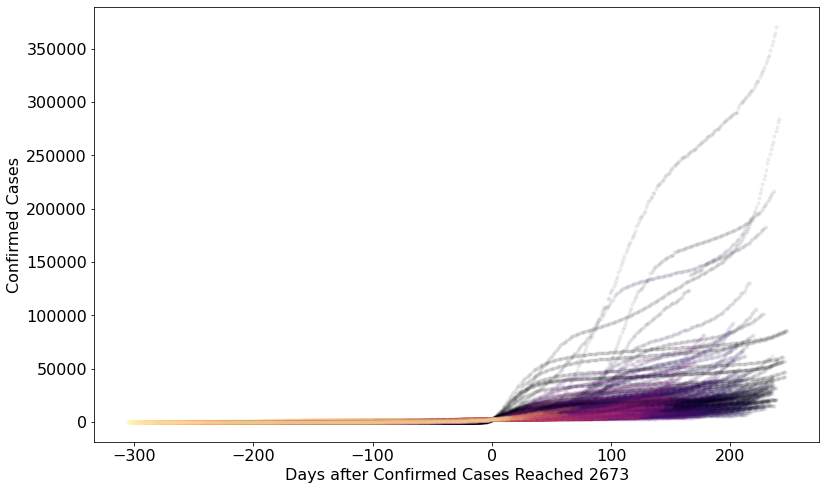

In [12]:
# Shift all the "Confirmed" time series so that day 0 is when each
# time series crosses the point where Manhattan was on 
# confirmed_day_zero_date.
# Linear plot.
# Color encodes how far the time series was shifted. Time series that
# were shifted by more days (i.e. more recent outbreaks) are in orange.
plot_aligned(cases["Confirmed"], "Confirmed Cases", day_zero_confirmed, log=False)

747 time series passed threshold of 2673


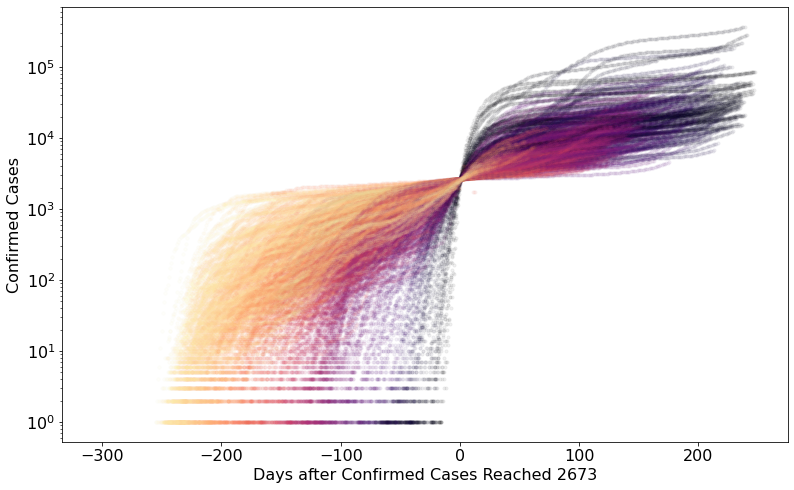

In [13]:
# Same plot as above, but with a logarithmic Y axis.
# Color encodes how far the time series was shifted. Time series that
# were shifted by more days (i.e. more recent outbreaks) are in orange.
plot_aligned(cases["Confirmed"], "Confirmed Cases", day_zero_confirmed, log=True)

3136 time series passed threshold of 0.16411801761643907


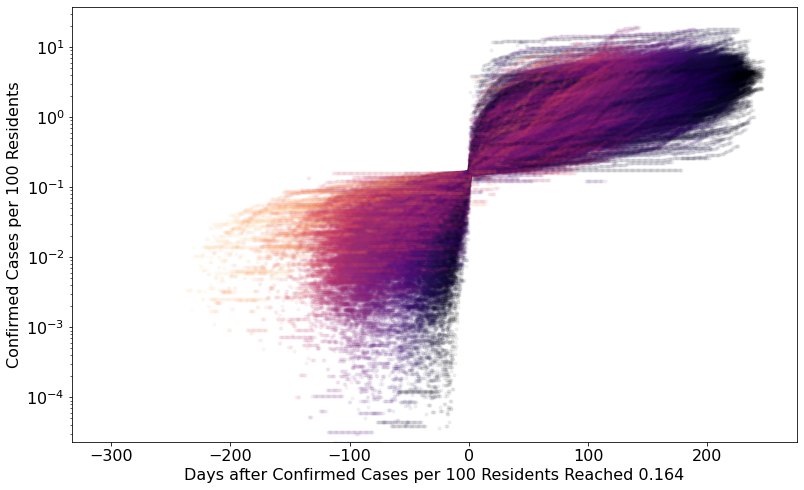

In [14]:
# Shift all the "Confirmed_per_100" time series so that they align at a single
# Y value. Semlilog plot.
# Color encodes how far the time series was shifted. Time series that
# were shifted by more days (i.e. more recent outbreaks) are in orange.
plot_aligned(cases_per_100["Confirmed_per_100"], "Confirmed Cases per 100 Residents",
             day_zero_confirmed_per_100, log=True)

89 time series passed threshold of 513


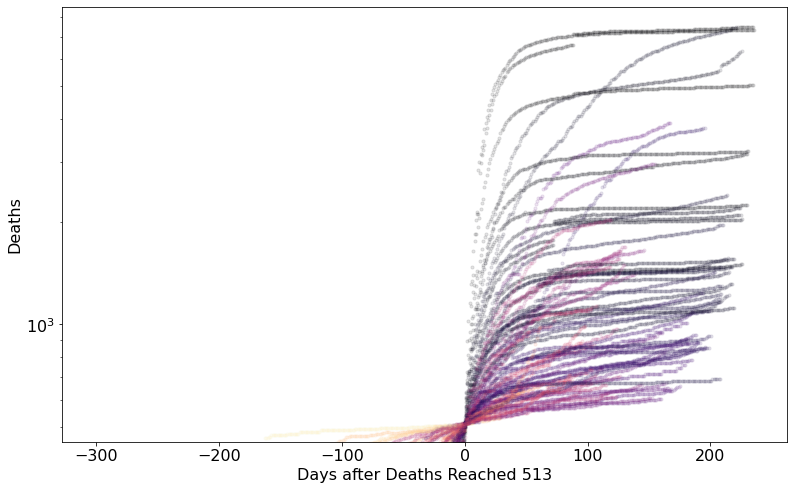

In [15]:
# Note the pronounced "rainbow" effect in the above plot. The more we 
# shifted a county's "confirmed cases" time series forward -- that is,
# the later the outbreak reached the county -- the lower the slope of
# the curve.
#
# This trend towards a flatter curve is probably due to several factors. 
# There were more public health measures in place at later dates, and 
# later outbreaks struck more sparsely-populated counties where the 
# average resident has contact with fewer other residents.

# Let's see if the time series of deaths produces the same result.

# Align all of the "Deaths" series. Log scale.
# Color encodes how far the time series was shifted. Time series that
# were shifted by more days (i.e. more recent outbreaks) are in orange.
plot_aligned(cases["Deaths"], "Deaths", day_zero_deaths, log=True)

2246 time series passed threshold of 0.03149739732032669


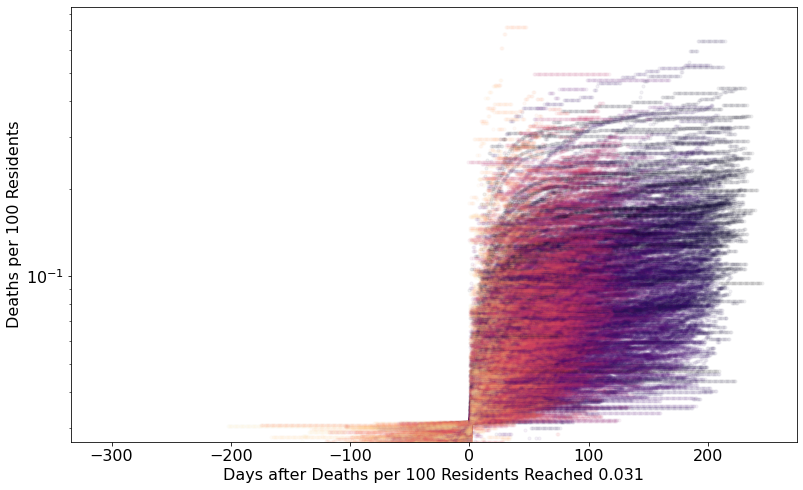

In [16]:
# Plot deaths per 100 residents, with day zero being when that value
# passed the value that NYC had on deaths_day_zero_date.
# Color encodes how far the time series was shifted. Time series that
# were shifted by more days (i.e. more recent outbreaks) are in orange.
plot_aligned(cases_per_100["Deaths_per_100"], "Deaths per 100 Residents",
             day_zero_deaths_per_100, log=True)

745 time series passed threshold of 0.03149739732032669


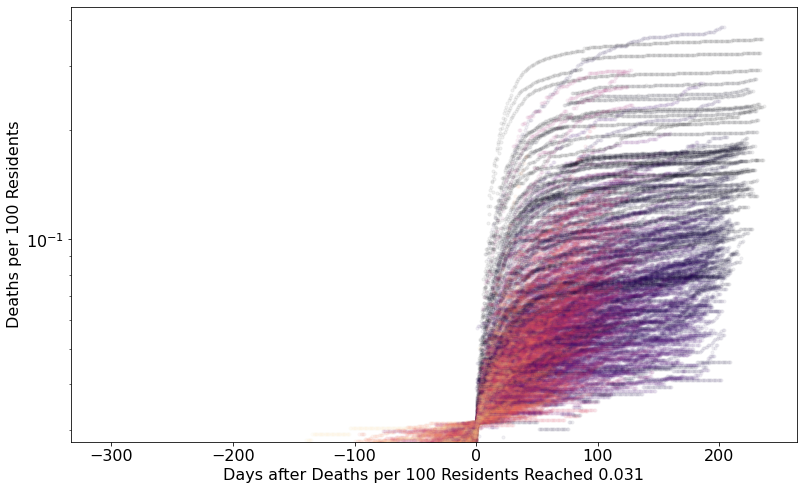

In [17]:
# Now the dominant factor in the plot is noise due to aliasing. 
# When the number of deaths goes from 1 to 2 in a sparsely-populated
# county, the normalized time series for that county experiences 
# a very large jump. 
#
# We can remove the aliasing-related noise from the above plot 
# by restricting the analysis to counties with population above a
# threshold.

# Filter out the time series subject to aliasing by filtering on population
pop_threshold = 50000
low_pop_cases = cases_per_100[cases_per_100["Population"] > pop_threshold]
plot_aligned(low_pop_cases["Deaths_per_100"], "Deaths per 100 Residents", 
             day_zero_deaths_per_100, log=True)